In [1]:
from collections import Counter
from math import e
from random import choice

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Imagine we are asked to participate in a survey that will use randomized response as a way to gaurantee plausible deniability. We want to first determine what our personal threshhold (loss function) is to participating. We can imagine that one or more of the questions we will be asked are sensitive. Here are a few examples:

- Have you knowingly consumed illegal drugs in the past month? 
- Have you tested positive for an Covid in the past 6 months?
- Have you ever lied to your boss?

Answering yes (or, arguably, no) to any of these responses would be considered quite sensitive in terms of personal privacy. We will take yes as the most sensitive response and say that if you toss a coin and it turns up heads (1), that you tell the truth in your response. If it turns up tails, you toss the coin again and you report No (0) if it comes up tails and Yes (1) if it comes up heads.  

Let's take a look at how this mechanism ensures differential privacy!

In [2]:
outcomes = [0, 1]
our_true_response = 1

In [3]:
coin_flip = choice(outcomes)
print ("Initial coin flip is %s" % coin_flip)
if coin_flip == 0:
    second_coin_flip = choice(outcomes)
    print("Second coin flip is %s" % second_coin_flip)

Initial coin flip is 1


In [4]:
def flip_coin(outcomes, our_response=1):
    coin_flip = choice(outcomes)
    if coin_flip == 1:
        return our_response
    second_coin_flip = choice(outcomes)
    return second_coin_flip

In [5]:
def randomized_response(outcomes, num_trails=100):
    return [flip_coin(outcomes) for x in range(num_trails)]

In [7]:
results = randomized_response(outcomes)
Counter(results)

Counter({1: 70, 0: 30})

<BarContainer object of 2 artists>

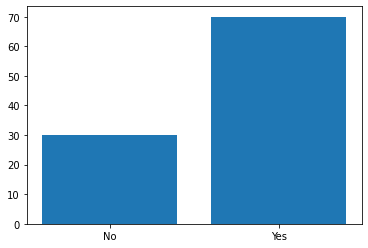

In [30]:
plt.bar(Counter(results).keys(), Counter(results).values(), tick_label=['Yes', 'No'])

We can see here the benefit of plausible deniability. Even though 100 of us would have answered yes, we see that there is always some proportion of no responses due to the randomized response mechanism. This protects all of us by allowing us culpable deniability. 

So for us personally, this aligns well with looking at our own probability distribution w.r.t the sensitive questions. If our true answer is yes we have:

P[A(Yes)=Yes]=0.75, P[A(Yes)=No]=0.25

75% chance of saying Yes, 25% chance of saying No.


If our true answer is no we have:

P[A(No)=Yes]=0.25, P[A(No)=No]=0.75

This difference shows a sensitivity of 3x (.25 * 3 = .75), which means our probability should be bounded by 3 in differential privacy, which would mean

e^epsilon = 3

Making epsilon ≃ 1.1 if we are using epsilon, 0 differential privacy :) 

In [13]:
e**1.1

3.0041660239464334

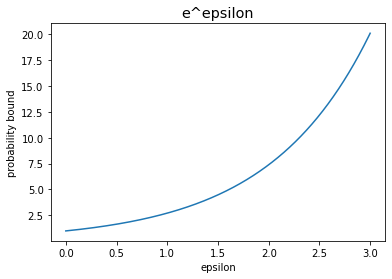

In [14]:
x = np.linspace(0,3,10000)
y = np.power(e,x)

fig,ax= plt.subplots()
plt.style.use('ggplot')
ax.plot(x,y);
ax.set_title('e^epsilon')
ax.set_xlabel('epsilon')
ax.set_ylabel('probability bound');

Of course, it also tells the researcher that there are quite a lot of true Yeses, due to the ratio of the outcomes above. Due to our epsilon bounds, we can say that the researcher can increase their probability of learning something about us by 3x with successive queries via this mechanism. Of course, we also have the power of large numbers in our favor here, meaning the researcher being able to link our exact response to us is quite rare and would require a targeted attack (or several). 

Now, how does the researcher learn from the survey? They would need to de-noise the data as best possible which means thinking about the biases they introduced with the differentially private mechanism.

How the researcher might try to de-noise the data is as follows.

In [40]:
def denoise_data(survey_results):
    results = Counter(survey_results)
    num_random_responses = len(survey_results) / len(results)
    denoised = {}
    for outcome, num_responses in results.items():
        if outcome == 0: 
            outcome = 'No'
        else:
            outcome = 'Yes'
        if num_responses > num_random_responses:
            denoised[outcome] = num_responses - num_random_responses
        else:
            denoised[outcome] = 0
            denoised['unaccounted'] = num_random_responses - num_responses
    return denoised

In [41]:
results = denoise_data(randomized_response(outcomes))

In [42]:
results

{'Yes': 18.0, 'No': 0, 'unaccounted': 18.0}

<BarContainer object of 3 artists>

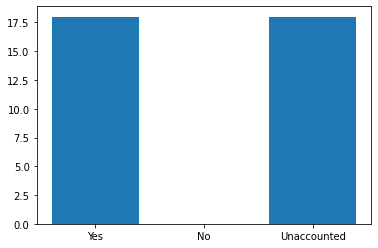

In [43]:
plt.bar(Counter(results).keys(), Counter(results).values(), tick_label=['Yes', 'No', 'Unaccounted'])

<BarContainer object of 3 artists>

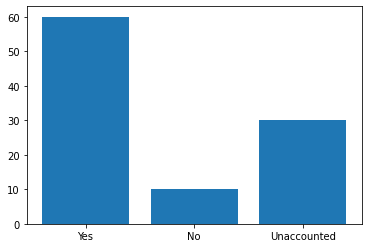

In [46]:
plt.bar([1, 2, 3], [60, 10, 30], tick_label=['Yes', 'No', 'Unaccounted'])

And one way to interpret this would be that we could guess that 44% of the population had a true answer of Yes. This is of course quite inaccurate compared to our knowledge that 100% of the population said yes, but it is a step in the right direction! Thus, we see both the accuracy limits and results of our randomized response! :)


### Challenge

How can we modify the functions above to show how it might work on different underlying distributions? (i.e. if 75% of the population would answer yes, or if 50% would answer yes?). What changes with the results and the accuracy? 


### Additional Challenge

If you were a researcher trained in Bayesian statistics, could you use a prior here that would allow you to have a more accurate takeaway from the response? (Or from future responses?). Asked in another way, what information have we learned from our initial survey that could inform future surveys by using an appropriate probability distribution function?

### Recommended Reading

- Ted on Privacy's Blog Series on Differential Privacy! https://desfontain.es/privacy/friendly-intro-to-differential-privacy.html